In [ ]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns
import math  
import datetime
import time
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import itertools
import keras
from sklearn.metrics import confusion_matrix
from keras.models import Sequential 
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# parameters will be used throughout
np.random.seed(2020)
num_folds = 5

### **Get data**

In [ ]:
# read data 
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRaXxo_XcKrx-PSEaHG3jZmVPk5bCP9yP5YYNWtT7L7jqreRaZ5fYjRSzJXXFgXaAdPk9pS10T53txO/pub?gid=612406421&single=true&output=csv")

# drop na (only 1 value)
data.dropna(inplace = True)
data.reset_index(inplace = True, drop = True)

# show basic stats
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.850065,120.919166,69.112125,20.533246,79.766623,31.996089,0.471585,33.249022,0.349413
std,3.368910,31.986187,19.367558,15.962378,115.315603,7.888704,0.331447,11.765742,0.477096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,29.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.500000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# convert data to numpy array
X = data[data.columns[:-1]].to_numpy()
y = data[data.columns[-1]].to_numpy()

# split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, stratify = y)

#Stratify = y to address the data imbalance (as mentioned in the report)

In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (536, 8) (536,)
Test:  (231, 8) (231,)


### **Baseline performance**

#### **Machine Learning**

In [ ]:
# perform cross validation on any sklearn models
# wrap them because they have the same properties

def get_CV_result(model, name):
  acc_list = []
  f1_list = []
  rec_list = []

  # kfold splitting for cross validation
  kfold_data = kfold.split(X_train, y_train)

  # train and record results for each model
  for train_ids, val_ids in kfold_data:
    cur_X_train = X_train[train_ids]
    cur_y_train = y_train[train_ids]
    cur_X_val = X_train[val_ids]
    cur_y_val = y_train[val_ids]

    # train
    model = model.fit(cur_X_train, cur_y_train)
    
    # predict
    cur_y_pred = model.predict(cur_X_val)

    # append results to the list
    f1_list.append(f1_score(cur_y_val, cur_y_pred))
    acc_list.append(accuracy_score(cur_y_val, cur_y_pred))
    rec_list.append(recall_score(cur_y_val, cur_y_pred))
  
  print("Model:", name)
  print(f"Val accuracy: {np.mean(acc_list):.2f} +- {2*np.std(acc_list):.2f}")
  print(f"Val f1_score: {np.mean(f1_list):.2f} +- {2*np.std(f1_list):.2f}")
  print(f"Val recall: {np.mean(rec_list):.2f} +- {2*np.std(rec_list):.2f}")

  # train on the bigger dataset
  model = model.fit(X_train, y_train)

  # prediction
  y_pred = model.predict(X_test)

  # metrics
  f1 = f1_score(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)

  # print results
  print("Test accuracy:", np.round(acc, 2))
  print("Test f1_score:", np.round(f1, 2))
  print("Test recall:", np.round(rec, 2))

In [ ]:
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2021)
#As mentioned in the report, we do this due to the small dataset


# initialize the model
models = [LogisticRegression(random_state=2021), SVC(random_state=2021), KNeighborsClassifier(n_neighbors=3)]
names = ["Logistic Regression", "SVM", "KNN"]

# perform 
for model, name in zip(models, names):
  get_CV_result(model, name)
  print("")

Model: Logistic Regression
Val accuracy: 0.79 +- 0.05
Val f1_score: 0.67 +- 0.10
Val recall: 0.60 +- 0.12
Test accuracy: 0.72
Test f1_score: 0.55
Test recall: 0.48

Model: SVM
Val accuracy: 0.77 +- 0.05
Val f1_score: 0.61 +- 0.11
Val recall: 0.53 +- 0.15
Test accuracy: 0.72
Test f1_score: 0.55
Test recall: 0.48

Model: KNN
Val accuracy: 0.74 +- 0.07
Val f1_score: 0.59 +- 0.17
Val recall: 0.56 +- 0.25
Test accuracy: 0.64
Test f1_score: 0.48
Test recall: 0.47



#### **Deep Learning**

In [ ]:
# f1 model for keras: retrieve from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
#f1 score is better than accuracy due to the imbalanced data 

# compute the keras model: 5 layers connected by RELU

def get_model():
  model = Sequential()  
  model.add(Flatten(input_shape=X_train.shape[1:]))  #nhét data vào  
  
  model.add(Dense(50)) 
  model.add(keras.layers.LeakyReLU(alpha=0.3)) 
  
  model.add(Dense(50))  
  model.add(keras.layers.LeakyReLU(alpha=0.3)) 
  
  model.add(Dense(100))  
  model.add(keras.layers.LeakyReLU(alpha=0.3))
  
  model.add(Dense(50))  
  model.add(keras.layers.LeakyReLU(alpha=0.3))
  
  model.add(Dense(50))  
  model.add(keras.layers.LeakyReLU(alpha=0.3))
  
  model.add(Dense(num_classes, activation='softmax')) #softmax because we have a classification problem

  # Using f1 as the metric as we strike for balance. Use cross entropy as loss function
  model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.Adam(),
                metrics=get_f1)  

  return model

In [ ]:
num_classes = 2
no_epochs = 50
batch_size = 30    

acc_list = []
f1_list = []
rec_list = []

print("KFold CV")

#cross validation

# Define K-Fold CV
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_idx = 1

dl_y_train = to_categorical(y_train)

for train_ids, val_ids in kfold.split(X_train, dl_y_train): 

  # get model
  model = get_model()

  print("Fold idx:", fold_idx)

  # use model checkpoint for best model
  mc = ModelCheckpoint("model.h5", monitor='val_get_f1', mode='max', save_best_only=True, save_weights_only= True)

  # Train model
  model.fit(X_train[train_ids], dl_y_train[train_ids],
              batch_size=batch_size,
              callbacks=[mc], 
              epochs=no_epochs,
              verbose=1, validation_data = (X_train[val_ids], dl_y_train[val_ids]))

  # load the weight from the best model
  model.load_weights("model.h5")
  
  # Test and print results
  cur_y_pred = np.argmax(model.predict(X_train[val_ids]), axis = 1)

  acc = accuracy_score(cur_y_pred, y_train[val_ids])
  f1 = f1_score(cur_y_pred, y_train[val_ids])
  rec = recall_score(cur_y_pred, y_train[val_ids])

  # Append the scores into the lists
  acc_list.append(acc)
  f1_list.append(f1)
  rec_list.append(rec)

  # Next fold
  fold_idx = fold_idx + 1

KFold CV
Fold idx: 1
Epoch 1/50
15/15 [==============================] - 2s 43ms/step - loss: 1.4535 - get_f1: 0.5963 - val_loss: 0.6494 - val_get_f1: 0.6944
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.8045 - get_f1: 0.6255 - val_loss: 0.6940 - val_get_f1: 0.6833
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.7334 - get_f1: 0.6459 - val_loss: 0.5241 - val_get_f1: 0.7444
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.6338 - get_f1: 0.6502 - val_loss: 0.6634 - val_get_f1: 0.6111
Epoch 5/50
15/15 [==============================] - 0s 6ms/step - loss: 0.6859 - get_f1: 0.6432 - val_loss: 0.5810 - val_get_f1: 0.7111
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6470 - get_f1: 0.6557 - val_loss: 0.5276 - val_get_f1: 0.7167
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.6222 - get_f1: 0.6525 - val_loss: 0.7389 - val_get_f1: 0.5639
Epoch 8/50
15/15 [========

In [ ]:
print('Results:')
print(f'Accuracy: {np.mean(acc_list):.2f} (+- {2*np.std(acc_list):.2f})')
print(f'F1-score: {np.mean(f1_list):.2f} (+- {2*np.std(f1_list):.2f})')
print(f'Recall: {np.mean(rec_list):.2f} (+- {2*np.std(rec_list):.2f})')

Results:
Accuracy: 0.76 (+- 0.06)
F1-score: 0.60 (+- 0.13)
Recall: 0.73 (+- 0.13)


In [ ]:
# convert data to keras digestible format
dl_y_train = to_categorical(y_train)
dl_y_test = to_categorical(y_test)


# get model
model = get_model()

# checkpointing
mc = ModelCheckpoint("model.h5", monitor='val_get_f1', mode='max', save_best_only=True, save_weights_only= True)

# Train model with all the train data
model.fit(X_train, dl_y_train,
            batch_size=batch_size,
            callbacks=[mc], 
            epochs=no_epochs,
            verbose=1, validation_data = (X_test, dl_y_test))

model.load_weights("model.h5")

Epoch 1/50
18/18 [==============================] - 1s 18ms/step - loss: 2.9821 - get_f1: 0.5685 - val_loss: 1.4327 - val_get_f1: 0.6280
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 1.0513 - get_f1: 0.5860 - val_loss: 0.8970 - val_get_f1: 0.5363
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.8032 - get_f1: 0.6194 - val_loss: 0.6635 - val_get_f1: 0.6387
Epoch 4/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5774 - get_f1: 0.6961 - val_loss: 0.7214 - val_get_f1: 0.6220
Epoch 5/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5574 - get_f1: 0.7346 - val_loss: 0.6441 - val_get_f1: 0.6262
Epoch 6/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5901 - get_f1: 0.6697 - val_loss: 0.6471 - val_get_f1: 0.6631
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5798 - get_f1: 0.7079 - val_loss: 0.6551 - val_get_f1: 0.6500
Epoch 8/50
18/18 [=============================

In [ ]:
# test prediction
cur_y_pred = np.argmax(model.predict(X_test), axis = 1)

# compute scores
acc = accuracy_score(cur_y_pred, y_test)
f1 = f1_score(cur_y_pred, y_test)
rec = recall_score(cur_y_pred, y_test)

print("Test accuracy:", np.round(acc, 2))
print("Test f1_score:", np.round(f1, 2))
print("Test recall:", np.round(rec, 2))

Test accuracy: 0.71
Test f1_score: 0.54
Test recall: 0.6


### **Improvements**

#### **Data improvement**

In [ ]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRaXxo_XcKrx-PSEaHG3jZmVPk5bCP9yP5YYNWtT7L7jqreRaZ5fYjRSzJXXFgXaAdPk9pS10T53txO/pub?gid=612406421&single=true&output=csv")

data.dropna(inplace = True)
data.reset_index(inplace = True, drop = True)

In [ ]:
# there are 0 values for these metrics, which does not make sense
# we should replace it with the median to make the data better
# too many values so we cannot delete them all

# vals = ["Glucose", "BloodPressure", "SkinThickness", "BMI"]
# for val in vals:
#   data[val] = data[val].apply(lambda x : np.median(data[val][data[val] != 0]) if (x==0) else x)

#HOWEVER: After implementation, I realized that these edits would affect the models. Also, the models wouldn't be 
#generalizable to other populations either. Therefore, I commented out the edits

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,102,52.0,0.0,0,25.1,0.078,21,0
1,6,87,80.0,0.0,0,23.2,0.084,32,0
2,2,90,70.0,17.0,0,27.3,0.085,22,0
3,1,173,74.0,0.0,0,36.8,0.088,38,1
4,2,114,68.0,22.0,0,28.7,0.092,25,0


In [ ]:
# convert data to numpy array
X = data[data.columns[:-1]].to_numpy()
y = data[data.columns[-1]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, stratify = y)

In [ ]:
# we use min max scaler (as our data is not normal)
# MinMax scaler would helps KNN (and trees) more than other regression methods, 
# but we should do it anyway to standardize the data

scaler = MinMaxScaler()

# fit on train data and transform the test based on this scaling
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (536, 8) (536,)
Test:  (231, 8) (231,)


#### **Machine learning (hyperparameter tuning)**

In [ ]:
# get the model and hyperparameters
models = [LogisticRegression(random_state=2021), SVC(random_state=2021), KNeighborsClassifier(n_neighbors=3)]
names = ["Logistic Regression", "SVM", "KNN"]
hyperparams = [{'penalty': ['l1', 'l2'], 'C': np.linspace(0, 4, 21)},  #Logistic
               {'C': np.linspace(0, 2, 21), 
                'kernel': ['linear' , 'poly' , 'rbf' , 'sigmoid']},  #SVM
               {'n_neighbors': list(range(1, 20))}  #KNN
               ] 

In [ ]:
# cross validation results
def get_CV_result(model, name, hyperparam):

  cv = 5
  # print(hyperparam)
  clf = GridSearchCV(model,
                     hyperparam,
                     cv=cv,
                     verbose=0,
                     n_jobs=-1,
                     scoring = "f1_weighted")
  
  # Fit gridsearch
  best_model = clf.fit(X_train, y_train)
  message = (best_model.best_score_, best_model.best_params_)

  # print the best hyperparameter
  print(f"Best f1 in validation: {best_model.best_score_:.2f} using {best_model.best_params_}")

  # predict again for X_test and get the results
  y_pred = best_model.predict(X_test)
  
  f1 = f1_score(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)

  print("Test accuracy:", np.round(acc, 2))
  print("Test f1_score:", np.round(f1, 2))
  print("Test recall:", np.round(rec, 2))

  return best_model.best_params_

In [ ]:
for model, name, hyperparam in zip(models, names, hyperparams):
  print(name)
  get_CV_result(model, name, hyperparam)
  print("")

Logistic Regression
Best f1 in validation: 0.78 using {'C': 3.4000000000000004, 'penalty': 'l2'}
Test accuracy: 0.72
Test f1_score: 0.54
Test recall: 0.47

SVM
Best f1 in validation: 0.78 using {'C': 0.1, 'kernel': 'poly'}
Test accuracy: 0.73
Test f1_score: 0.54
Test recall: 0.44

KNN
Best f1 in validation: 0.75 using {'n_neighbors': 12}
Test accuracy: 0.71
Test f1_score: 0.5
Test recall: 0.42



#### **Deep Learning**

In [ ]:
# get f1 score

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    
# use the variable to set up the hyperparameters
def get_model(lr, layers=5, drop_out=False):

  model = Sequential()  
  model.add(Flatten(input_shape=X_train.shape[1:]))  

  if layers >= 1:
    model.add(Dense(50))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    if drop_out:
      model.add(Dropout(0.2))  
  
  if layers >= 2:
    model.add(Dense(50))  
    model.add(keras.layers.LeakyReLU(alpha=0.3)) 
    if drop_out:
      model.add(Dropout(0.2))

  if layers >= 3:
    model.add(Dense(100))  
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    if drop_out:
      model.add(Dropout(0.2))

  if layers >= 4:
    model.add(Dense(50))  
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    if drop_out:
      model.add(Dropout(0.2))

  if layers >= 5:
    model.add(Dense(50))  
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    if drop_out:
      model.add(Dropout(0.2))

  model.add(Dense(num_classes, activation='softmax'))  

  # set up the parameters with f1 score metric
  optimizer = optimizers.Adam(lr=lr)
  model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizer,
                metrics=get_f1)  

  return model

  #dropout is to minimize overfit, and test with different learning rates which are akin to step sizes in gradient descent

In [ ]:
%%time
# set up the classifier
model = KerasClassifier(build_fn=get_model, verbose=0)

# define the grid search parameters
# different kind of epoch, batch size, learning rate, and drop_out or not
batch_size = [30, 40, 50]
epochs = [30, 40, 50]
lr = [1e-3, 1e-4]
drop_out=[False, True]
layers = [2, 3, 4]

# doing grid search optimization
param_grid = dict(batch_size=batch_size, epochs=epochs, lr=lr, drop_out=drop_out, layers = layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_weighted')
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("")

In [ ]:
# use the best hyperparameters to train

x = grid_result.best_params_
dl_y_train = to_categorical(y_train)
dl_y_test = to_categorical(y_test)
model = get_model(x['lr'], x['drop_out'])

# checkpointing best model
mc = ModelCheckpoint("model.h5", monitor='val_get_f1', mode='max', save_best_only=True, save_weights_only= True)

# Train model
history = model.fit(X_train, dl_y_train,
            batch_size=x['batch_size'],
            callbacks=[mc], 
            epochs=x['epochs'],
            verbose=1, validation_data = (X_test, dl_y_test))

model.load_weights("model.h5")

Epoch 1/40
18/18 [==============================] - 1s 18ms/step - loss: 0.6772 - get_f1: 0.6263 - val_loss: 0.6623 - val_get_f1: 0.6446
Epoch 2/40
18/18 [==============================] - 0s 7ms/step - loss: 0.6676 - get_f1: 0.6289 - val_loss: 0.6553 - val_get_f1: 0.6446
Epoch 3/40
18/18 [==============================] - 0s 6ms/step - loss: 0.6480 - get_f1: 0.6495 - val_loss: 0.6490 - val_get_f1: 0.6363
Epoch 4/40
18/18 [==============================] - 0s 7ms/step - loss: 0.6340 - get_f1: 0.6541 - val_loss: 0.6431 - val_get_f1: 0.6405
Epoch 5/40
18/18 [==============================] - 0s 6ms/step - loss: 0.6157 - get_f1: 0.6814 - val_loss: 0.6379 - val_get_f1: 0.6405
Epoch 6/40
18/18 [==============================] - 0s 6ms/step - loss: 0.6128 - get_f1: 0.6705 - val_loss: 0.6326 - val_get_f1: 0.6405
Epoch 7/40
18/18 [==============================] - 0s 5ms/step - loss: 0.5960 - get_f1: 0.7059 - val_loss: 0.6272 - val_get_f1: 0.6488
Epoch 8/40
18/18 [=============================

In [ ]:
# best val score
print("Val score for the best model", max(history.history['get_f1']))

# the test score for the corrresponding model that produces the best val score
print("Test score for the best model", history.history['val_get_f1'][np.argmax(history.history['get_f1'])])

Val score for the best model 0.7901708483695984
Test score for the best model 0.7178570628166199


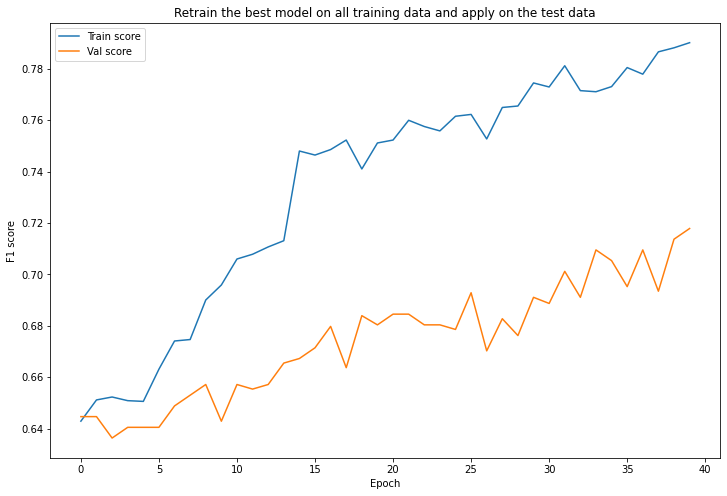

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))
plt.plot(range(len(history.history['get_f1'])), history.history['get_f1'], label = "Train score")
plt.plot(range(len(history.history['val_get_f1'])), history.history['val_get_f1'], label = "Val score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Retrain the best model on all training data and apply on the test data")
plt.legend()
plt.show()

In [ ]:
# use the best hyperparameters to train

x = grid_result.best_params_
dl_y_train = to_categorical(y_train)
dl_y_test = to_categorical(y_test)
model = get_model(x['lr'], x['drop_out'])

# checkpointing best model
mc = ModelCheckpoint("model.h5", monitor='val_get_f1', mode='max', save_best_only=True, save_weights_only= True)

# Train model
history = model.fit(X_train, dl_y_train,
            batch_size=x['batch_size'],
            callbacks=[mc], 
            epochs=100,
            verbose=1, validation_data = (X_test, dl_y_test))

model.load_weights("model.h5")

Epoch 1/100
18/18 [==============================] - 1s 16ms/step - loss: 0.6768 - get_f1: 0.6373 - val_loss: 0.6579 - val_get_f1: 0.6446
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6483 - get_f1: 0.6586 - val_loss: 0.6514 - val_get_f1: 0.6446
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6289 - get_f1: 0.6665 - val_loss: 0.6449 - val_get_f1: 0.6321
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6353 - get_f1: 0.6303 - val_loss: 0.6387 - val_get_f1: 0.6321
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6137 - get_f1: 0.6623 - val_loss: 0.6327 - val_get_f1: 0.6321
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5935 - get_f1: 0.6922 - val_loss: 0.6270 - val_get_f1: 0.6280
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6007 - get_f1: 0.6940 - val_loss: 0.6225 - val_get_f1: 0.6262
Epoch 8/100
18/18 [=====================

In [ ]:
# best val score
print("Val score for the best model", max(history.history['get_f1']))

# the test score for the corrresponding model that produces the best val score
print("Test score for the best model", history.history['val_get_f1'][np.argmax(history.history['get_f1'])])

Val score for the best model 0.8081195950508118
Test score for the best model 0.7238094210624695


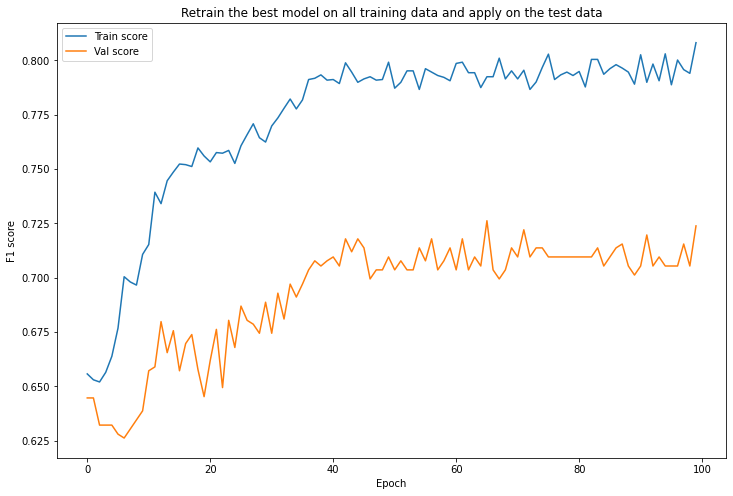

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(range(len(history.history['get_f1'])), history.history['get_f1'], label = "Train score")
plt.plot(range(len(history.history['val_get_f1'])), history.history['val_get_f1'], label = "Val score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Retrain the best model on all training data and apply on the test data")
plt.legend()
plt.show()